In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from cubic_spline import cubic_spline_evaluate

import agama
agama.setUnits(mass=1, length=1, velocity=1)

In [13]:
@jax.jit
def jax_phi_m_eval(m, x, y, z, Rgrid, Zgrid, rho_real, rho_img, Mx_real, My_real, Mx_img, My_img):

    R, ph = jnp.sqrt(x*x + y*y), jnp.arctan2(y, x)
    real_values = rho_real[m]
    imag_values = rho_img[m]
    M_x_real = Mx_real[m]
    M_y_real = My_real[m]
    M_x_imag = Mx_img[m]
    M_y_imag = My_img[m]

    shape = R.shape
    pts = jnp.column_stack((R.ravel(), jnp.abs(z).ravel()))

    real_part = cubic_spline_evaluate(pts, (Rgrid, Zgrid), real_values, M_x_real, M_y_real, fill_value=0.0).reshape(shape)
    imag_part = cubic_spline_evaluate(pts, (Rgrid, Zgrid), imag_values, M_x_imag, M_y_imag, fill_value=0.0).reshape(shape)

    phi_m = real_part + 1j * imag_part

    val = (phi_m.real * jnp.cos(m*ph) - phi_m.imag * jnp.sin(m*ph))

    val_final = jax.lax.cond(m==0, lambda: val, lambda: val*2)

    return val_final

def get_pot_from_coord(x,y,z):
    phi_grid = jax.vmap(jax_phi_m_eval, in_axes=(0, None, None, None, None, None, None, None, None, None, None, None))(
        M.astype(int), x, y, z, R, Z_nonneg, phi_real, phi_img, phi_Mx_real, phi_My_real, phi_Mx_img, phi_My_img)
    return jnp.sum(phi_grid, axis=0)

with open('./pot_data/MN_disc.pkl', 'rb') as f:
    pot_data = pickle.load(f)

R = pot_data['Rgrid']
Z_nonneg = pot_data['Zgrid']
M = pot_data['m']
phi_real = pot_data['Phi_m_real']
phi_img = pot_data['Phi_m_img']
phi_Mx_real = pot_data['Mx_real']
phi_My_real = pot_data['My_real']
phi_Mx_img = pot_data['Mx_img']
phi_My_img = pot_data['My_img']


100%|██████████| 100/100 [00:00<00:00, 2352.29it/s]


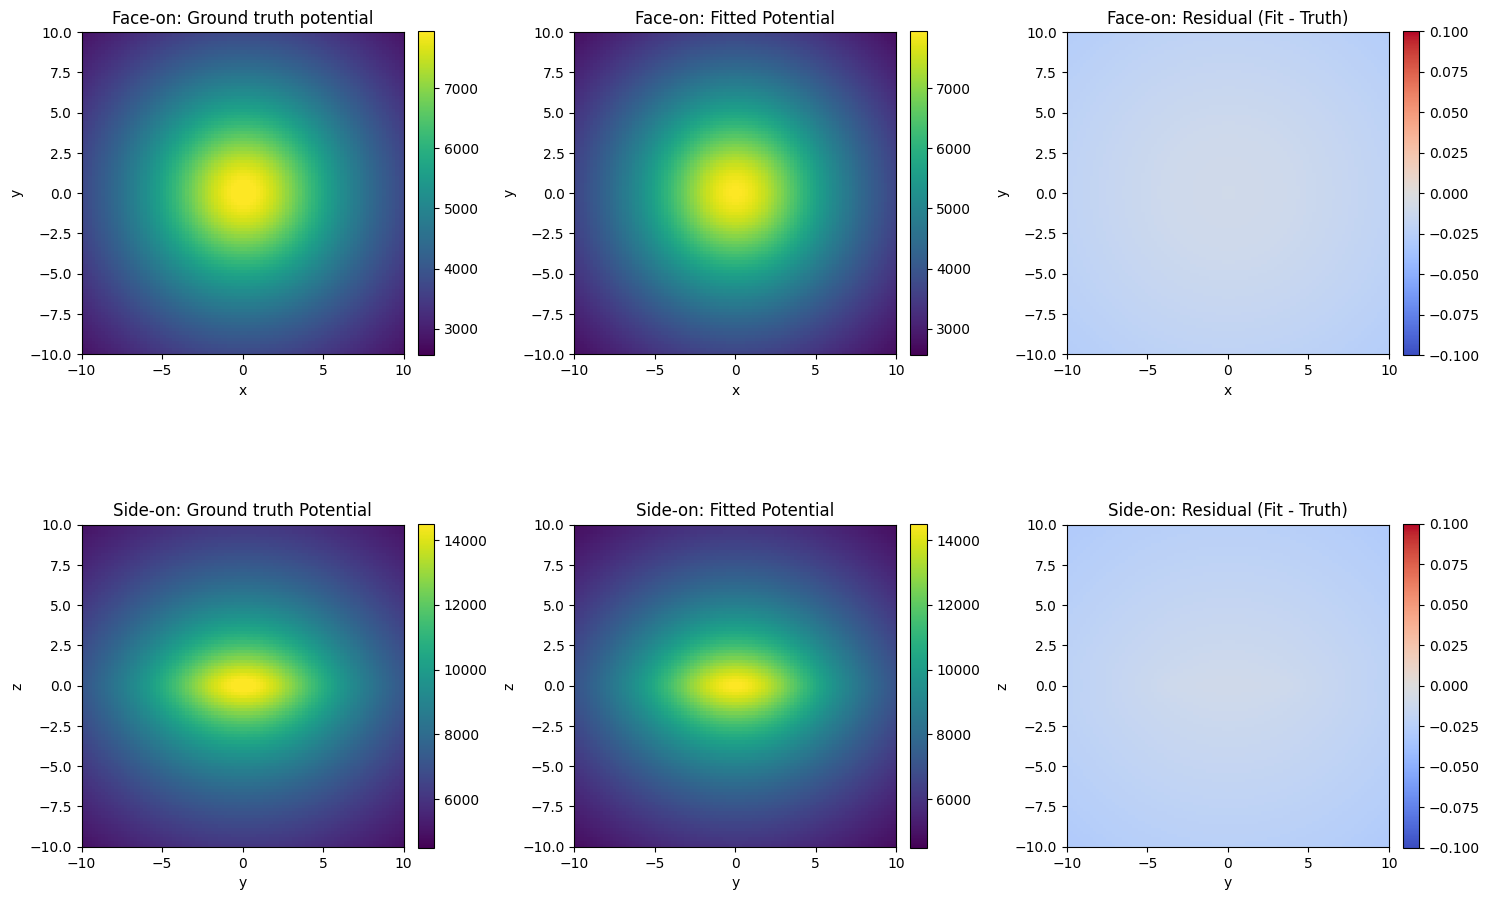

In [14]:
def mn_phi_cyl(R, z, M, a, b, G):
    """
    Miyamoto–Nagai potential Φ(R,z) = - G M / sqrt(R^2 + (a + sqrt(z^2 + b^2))^2)
    """
    R = np.asarray(R, float); z = np.asarray(z, float)
    beta = np.sqrt(z*z + b*b)
    D = np.sqrt(R*R + (a + beta)**2)
    return -G * M / D
def mn_phi_cart(x, y, z, M=1e9, a=3, b=0.8, G=4.3e-6):
    x = np.asarray(x, float); y = np.asarray(y, float); z = np.asarray(z, float)
    R = np.sqrt(x*x + y*y)
    return mn_phi_cyl(R, z, M=M, a=a, b=b, G=G)

def Phi_gt(pts):
    x, y, z = pts[:,0], pts[:,1], pts[:,2]
    return mn_phi_cart(x, y, z)

from tqdm import tqdm

nx = 100
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, nx)
X, Y = np.meshgrid(x, y)
Z = np.linspace(-5, 5, nx)
dZ = Z[1] - Z[0]
Y2 = np.linspace(-10, 10, nx)
Z2 = np.linspace(-10, 10, nx)
Yg, Zg = np.meshgrid(Y2, Z2)
X2 = np.linspace(-10, 10, nx)
# X2 = np.array([-0.1,0.1])#np.linspace(-10, 10, nx)
dX = X2[1] - X2[0]


Potential_agama_faceon = np.zeros_like(X)
for i in tqdm(range(len(Z))):

    z_slice = Z[i]
    # r, th, ph = cart_to_sph(np.full_like(Yg, x_slice), Yg, Zg)
    points = np.column_stack((X.ravel(), Y.ravel(), np.full_like(X.ravel(), z_slice)))
    Potential_agama_faceon += (Phi_gt(points) * dZ).reshape(X.shape)

Potential_fit_faceon = np.zeros_like(X)
for i in tqdm(range(len(Z))):
    z_slice = Z[i]
    Potential_fit_faceon += (get_pot_from_coord(X, Y, np.full_like(X, z_slice)) * dZ)
# for i in tqdm(range(len(Z))):
#     z_slice = Z[i]
#     points = np.column_stack((X.ravel(), Y.ravel(), np.full_like(X.ravel(), z_slice)))
#     Potential_fit_faceon += (pot_agama.potential(points) * dZ).reshape(X.shape)


Potential_agama_sideon = np.zeros_like(Yg)
for i in tqdm(range(len(X2))):
    x_slice = X2[i]
    # r, th, ph = cart_to_sph(np.full_like(Yg, x_slice), Yg, Zg)
    points = np.column_stack((np.full_like(Yg.ravel(), x_slice), Yg.ravel(), Zg.ravel()))
    Potential_agama_sideon += (Phi_gt(points) * dX).reshape(Yg.shape)

Potential_fit_sideon = np.zeros_like(Yg)
for i in tqdm(range(len(X2))):
    x_slice = X2[i]
    Potential_fit_sideon += (get_pot_from_coord(np.full_like(Yg, x_slice), Yg, Zg) * dX)
# for i in tqdm(range(nx)):
#     x_slice = X2[i]
#     points = np.column_stack((np.full_like(Yg.ravel(), x_slice), Yg.ravel(), Zg.ravel()))
#     Potential_fit_sideon += (pot_agama.potential(points) * dX).reshape(Yg.shape)

# Residual (side-on)
Potential_residual_faceon = Potential_fit_faceon - Potential_agama_faceon
Potential_residual_sideon = Potential_fit_sideon - Potential_agama_sideon

# --- Plotting ---
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

vmin = np.min([-Potential_agama_faceon.min(), -Potential_fit_faceon.min()])
vmax = np.max([-Potential_agama_faceon.max(), -Potential_fit_faceon.max()])
# Face-on
im0 = axs[0, 0].imshow(-Potential_agama_faceon, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis',
vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Face-on: Ground truth potential')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

im1 = axs[0, 1].imshow(-Potential_fit_faceon, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis',
vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Face-on: Fitted Potential')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

im2 = axs[0, 2].imshow(Potential_residual_faceon/Potential_agama_faceon, origin='lower', 
extent=[x.min(), x.max(), y.min(), y.max()], cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[0, 2].set_title('Face-on: Residual (Fit - Truth)')
plt.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)

for ax in axs[0, :]:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Side-on
vmin = np.min([-Potential_agama_sideon.min(), -Potential_fit_sideon.min()])
vmax = np.max([-Potential_agama_sideon.max(), -Potential_fit_sideon.max()])
im3 = axs[1, 0].imshow(-Potential_agama_sideon, origin='lower', extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='viridis',
vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Side-on: Ground truth Potential')
plt.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04)

im4 = axs[1, 1].imshow(-Potential_fit_sideon, origin='lower', extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='viridis',
vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Side-on: Fitted Potential')
plt.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04)

im5 = axs[1, 2].imshow(Potential_residual_sideon/Potential_agama_sideon, origin='lower',
extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[1, 2].set_title('Side-on: Residual (Fit - Truth)')
plt.colorbar(im5, ax=axs[1, 2], fraction=0.046, pad=0.04)

for ax in axs[1, :]:
    ax.set_xlabel('y')
    ax.set_ylabel('z')

plt.tight_layout()


# plt.figure()
# plt.hist((Potential_agama_faceon/Potential_fit_faceon).ravel(), bins = 100)
# plt.hist((Potential_agama_sideon/Potential_fit_sideon).ravel(), bins = 100)
# plt.show()

In [15]:
def double_exponential(R, z, Sigma0=1.0, Rd=2.5, hz=0.3):
    """Volume density for a simple exponential disc: rho(R,z) = (Sigma0/(2hz)) e^{-R/Rd} e^{-|z|/hz}."""
    return (Sigma0 / (2.0 * hz)) * jnp.exp(-R / Rd) * jnp.exp(-jnp.abs(z) / hz)

def ferrers_bar_density(x, y, z, a=3.5, b=1.5, c=1.0, rho0=0.02, n=2, phi_bar=25.0*jnp.pi/180.0):
    """
    Ferrers bar: rho = rho0 (1 - m^2)^n  for m^2 = x'^2/a^2 + y'^2/b^2 + z'^2/c^2 < 1, else 0.
    The bar major axis a is rotated in the x–y plane by phi_bar (radians) from +x.
    """
    cp, sp = jnp.cos(phi_bar), jnp.sin(phi_bar)
    xp =  cp * x + sp * y
    yp = -sp * x + cp * y
    zp = z
    m2 = (xp / a) ** 2 + (yp / b) ** 2 + (zp / c) ** 2
    inside = (m2 < 1.0)
    rho = jnp.zeros_like(x, dtype=float)
    # rho = rho.at[inside].set(rho0 * (1.0 - m2[inside]) ** n)
    rho = jnp.where(inside, rho0 * (1.0 - m2) ** n, 0.0)
    return rho

def double_expo_plus_ferrers_bar_xyz(
    x, y, z,
    # thin disc
    Sigma0_thin=1.0, Rd_thin=3.0, hz_thin=0.2,
    # thick disc
    Sigma0_thick=1.0, Rd_thick=1.8, hz_thick=0.8,
    # bar
    a_bar=4, b_bar=1.5, c_bar=0.8, rho0_bar=1., n_bar=2, phi_bar_deg=25.0
):
    """
    Composite test density: thin+thick exponential discs + Ferrers bar.
    Returns rho(x,y,z).
    """
    R = jnp.sqrt(x*x + y*y)
    phi_bar = jnp.deg2rad(phi_bar_deg)

    rho_thin  = double_exponential(R, z, Sigma0=Sigma0_thin,  Rd=Rd_thin,  hz=hz_thin)
    rho_thick = double_exponential(R, z, Sigma0=Sigma0_thick, Rd=Rd_thick, hz=hz_thick)
    rho_bar   = ferrers_bar_density(x, y, z, a=a_bar, b=b_bar, c=c_bar, rho0=rho0_bar, n=n_bar, phi_bar=phi_bar)

    return rho_thin + rho_thick + rho_bar

@jax.jit
def rho_xyz(x,y,z):

    return double_expo_plus_ferrers_bar_xyz(x, y, z)

def get_pot_from_coord(x,y,z):
    phi_grid = jax.vmap(jax_phi_m_eval, in_axes=(0, None, None, None, None, None, None, None, None, None, None, None))(
        M.astype(int), x, y, z, R, Z_nonneg, phi_real, phi_img, phi_Mx_real, phi_My_real, phi_Mx_img, phi_My_img)
    return jnp.sum(phi_grid, axis=0)

with open('./pot_data/DiscBar_disc.pkl', 'rb') as f:
    pot_data = pickle.load(f)

R = pot_data['Rgrid']
Z_nonneg = pot_data['Zgrid']
M = pot_data['m']
phi_real = pot_data['Phi_m_real']
phi_img = pot_data['Phi_m_img']
phi_Mx_real = pot_data['Mx_real']
phi_My_real = pot_data['My_real']
phi_Mx_img = pot_data['Mx_img']
phi_My_img = pot_data['My_img']

100%|██████████| 100/100 [00:00<00:00, 2024.04it/s]


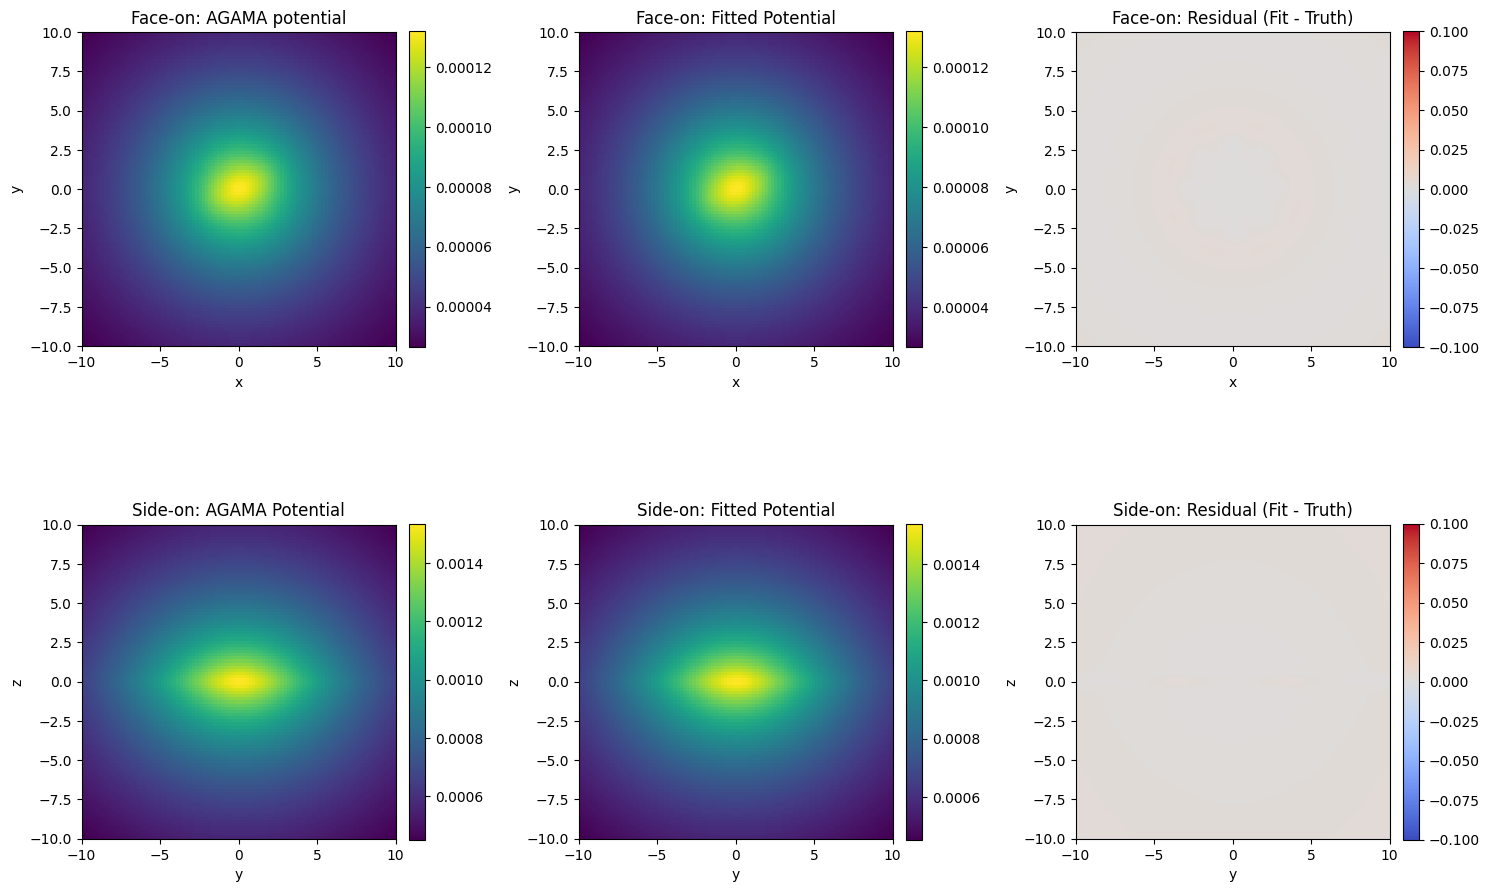

In [17]:

def rho_gt(x, y, z):
    return double_expo_plus_ferrers_bar_xyz(x, y, z)

# --- Projected surface density maps: face-on (z=0) and side-on (y=0) ---

# Face-on: integrate along z, grid in (x, y)
nx = 100
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, nx)
X, Y = np.meshgrid(x, y)
Z = np.linspace(-0.5, 0.5, nx)
dZ = Z[1] - Z[0]

def rho_input(x):
    return np.array(rho_gt(x[:,0], x[:,1], x[:,2]))

pot_agama = agama.Potential(type='Cylspline', density=rho_input, gridSizeR=30, rmin=1e-2, rmax=20,zmin=1e-2, zmax=15,
                    symmetry = 'none', mmax=7)



Potential_agama_faceon = np.zeros_like(X)
for i in tqdm(range(len(Z))):

    z_slice = Z[i]
    # r, th, ph = cart_to_sph(np.full_like(Yg, x_slice), Yg, Zg)
    points = np.column_stack((X.ravel(), Y.ravel(), np.full_like(X.ravel(), z_slice)))
    Potential_agama_faceon += (pot_agama.potential(points) * dZ).reshape(X.shape)

Potential_fit_faceon = np.zeros_like(X)
for i in tqdm(range(len(Z))):
    z_slice = Z[i]
    Potential_fit_faceon += (get_pot_from_coord(X, Y, np.full_like(X, z_slice)) * dZ)


Potential_agama_sideon = np.zeros_like(Yg)
for i in tqdm(range(len(X2))):
    x_slice = X2[i]
    # r, th, ph = cart_to_sph(np.full_like(Yg, x_slice), Yg, Zg)
    points = np.column_stack((np.full_like(Yg.ravel(), x_slice), Yg.ravel(), Zg.ravel()))
    Potential_agama_sideon += (pot_agama.potential(points) * dX).reshape(Yg.shape)

Potential_fit_sideon = np.zeros_like(Yg)
for i in tqdm(range(len(X2))):
    x_slice = X2[i]
    Potential_fit_sideon += (get_pot_from_coord(np.full_like(Yg, x_slice), Yg, Zg) * dX)

# Residual (side-on)
Potential_residual_faceon = Potential_fit_faceon - Potential_agama_faceon
Potential_residual_sideon = Potential_fit_sideon - Potential_agama_sideon

# --- Plotting ---
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Face-on
im0 = axs[0, 0].imshow(-Potential_agama_faceon, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis',
)
axs[0, 0].set_title('Face-on: AGAMA potential')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

im1 = axs[0, 1].imshow(-Potential_fit_faceon, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis',
)
axs[0, 1].set_title('Face-on: Fitted Potential')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

im2 = axs[0, 2].imshow(Potential_residual_faceon/Potential_agama_faceon, origin='lower', 
extent=[x.min(), x.max(), y.min(), y.max()], cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[0, 2].set_title('Face-on: Residual (Fit - Truth)')
plt.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)

for ax in axs[0, :]:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Side-on
im3 = axs[1, 0].imshow(-Potential_agama_sideon, origin='lower', extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='viridis',
)
axs[1, 0].set_title('Side-on: AGAMA Potential')
plt.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04)

im4 = axs[1, 1].imshow(-Potential_fit_sideon, origin='lower', extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='viridis',
)
axs[1, 1].set_title('Side-on: Fitted Potential')
plt.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04)

im5 = axs[1, 2].imshow(Potential_residual_sideon/Potential_agama_sideon, origin='lower',
extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[1, 2].set_title('Side-on: Residual (Fit - Truth)')
plt.colorbar(im5, ax=axs[1, 2], fraction=0.046, pad=0.04)

for ax in axs[1, :]:
    ax.set_xlabel('y')
    ax.set_ylabel('z')

plt.tight_layout()
plt.show()
